In [ ]:
#install dependencies if not installed
!pip install opencv-python
!pip install dlib -q
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

In [1]:
import os
import random
from tqdm import tqdm
from typing import Union, List

import dlib
from tqdm import tqdm
import numpy as np
from imutils import face_utils
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

import transformers
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Let's start by loading the LFW dataset. We'll create two subsets: a training set (lfw) and a testing set (lfw_test).
- "train" specifies the training subset.
- "test" specifies the testing subset.
- download=True downloads the dataset if it's not already available locally.

Then we will define a function to detect faces, here I use simple dblib package for that. However, it's worth noting that you can also explore other deep learning-based approaches like MTCNN or Single Shot MultiBox Detector (SSD) for face detection.

In [43]:
lfw = datasets.LFWPeople("./data", "train", download=True)
lfw_test = datasets.LFWPeople("./data", "test", download=True)

Files already downloaded and verified
Files already downloaded and verified


In [44]:
def detect_faces(img: Union[np.array, Image.Image], transforms: transforms.Compose=None, size: int=250):
    """
    Detect faces in an input image and return information about the detected faces.

    Args:
        img (Union[np.array, Image.Image]): Input image containing faces.
        transforms (transforms.Compose, optional): A transformation pipeline to apply to detected faces.
        size (int, optional): Size of the detected face images. Default is 250 pixels.

    Returns:
        List[Tuple[np.array, Tuple[int, int, int, int], np.array]]: A list of tuples containing:
            - Detected face image as a NumPy array.
            - Bounding box coordinates (x, y, width, height) of the detected face.
            - Facial landmarks as a NumPy array.

    Notes:
        - The input image can be either a NumPy array or a PIL Image.
        - If a transformation pipeline is provided, it will be applied to the detected faces.
        - The function uses the dlib library for face detection and facial landmark prediction.
        - Each tuple in the returned list corresponds to a detected face in the input image.
    """
    res = []
    detector = dlib.get_frontal_face_detector()
    sp = dlib.shape_predictor("./shape_predictor_5_face_landmarks.dat")

    if isinstance(img, Image.Image):
        img = np.array(img)
    detections = detector(img, 1)

    for detection in detections:
        img_shape = sp(img, detection)
        detected_face = dlib.get_face_chip(img, img_shape, size=size)
        if transforms:
            detected_face = transforms(detected_face)

        shape = face_utils.shape_to_np(img_shape)
        box_coord = face_utils.rect_to_bb(detection)
        res.append((detected_face, box_coord, shape))
    return res

<Figure size 640x480 with 0 Axes>

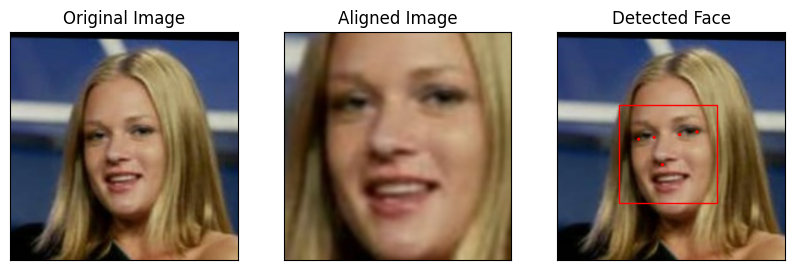

In [45]:
processed, box, shape = detect_faces(lfw[0][0])[0]
x, y, w, h = box
orig = np.array(lfw[0][0])

plt.figure()
f, axarr = plt.subplots(1, 3, figsize=(10, 10)) 
axarr[0].imshow(orig)
axarr[1].imshow(processed)
axarr[2].imshow(orig)

rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
axarr[2].add_patch(rect)
for (x, y) in shape:
    circle = plt.Circle((x, y), 1, color='r')
    axarr[2].add_patch(circle)

axarr[0].title.set_text('Original Image')
axarr[1].title.set_text('Aligned Image')
axarr[2].title.set_text('Detected Face')

for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
# This code segment reads information about the LFW (Labeled Faces in the Wild) dataset from a text file,
# organizes it into dictionaries, and preprocesses the images of faces using a face detection function.

with open("./data/lfw-py/lfw-names.txt", "r") as f:
    names = f.readlines()

names_dict = {}
name2img = {}

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

for el in tqdm(names):
    name, num_images = el.split("\t")
    names_dict[name] = int(num_images.strip())
    name2img[name] = []
    img_folder = os.path.join("./data/lfw-py/lfw_funneled", name)
    all_images = os.listdir(img_folder)
    for img in all_images:
        img_file = os.path.join(img_folder, img)
        image = Image.open(img_file)
        
        faces = detect_faces(image, transforms=transform)
        if faces:
            face = faces[0][0]
            name2img[name].append(face)

In [2]:
# I already saved detected faces, so I'll just load them
import pickle

with open("./data/lfw-py/lfw-names.txt", "r") as f:
    names = f.readlines()

with open("./name2img.pickle", "rb") as f:
    name2img = pickle.load(f)

In [3]:
# After detecting faces, some people's images were discarded for not finding the face of the photo
# You can use a better face detection like MTCNN

names_dict = {}
names_without_image = []
names_with_less_image = []
for el in tqdm(names):
    name, num_images = el.split("\t")
    num = int(num_images.strip())
    names_dict[name] = num
    detected_num = len(name2img[name])
    if detected_num == 0:
        names_without_image.append(name)
    elif num > detected_num:
        names_with_less_image.append(name)
    if detected_num != num:
        print(name, num, detected_num)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5749/5749 [00:00<00:00, 708915.56it/s]

Abdoulaye_Wade 4 3
Angela_Merkel 5 4
Anna_Kournikova 12 11
Ariel_Sharon 77 76
Arlen_Specter 3 2
Arnold_Schwarzenegger 42 40
Brandon_Webb 1 0
Brian_Schneider 1 0
Britney_Spears 14 13
Chris_Andrews 1 0
Colin_Montgomerie 5 4
Dale_Earnhardt_Jr 4 3
Derrick_Rodgers 1 0
Don_Hewitt 1 0
Donald_Rumsfeld 121 120
Elena_de_Chavez 1 0
Elisabeth_Schumacher 2 1
Ernie_Stewart 1 0
Franz_Muentefering 4 3
George_Galloway 4 3
George_W_Bush 530 529
Guillermo_Coria 30 28
Hernan_Diaz 1 0
Ira_Einhorn 1 0
Jacques_Chirac 52 50
James_McGreevey 4 3
Jane_Fonda 2 1
Jaouad_Gharib 1 0
Jeff_Feldman 1 0
Jelena_Dokic 8 7
Jessica_Lynch 2 1
Joe_Vandever 1 0
John_Burkett 1 0
John_Manley 7 6
John_Thune 1 0
Jon_Stewart 1 0
Kaye_Young 1 0
Kultida_Woods 1 0
Luis_Horna 6 5
Mark_Heller 2 1
Meryl_Streep 15 14
Nabil_Shaath 3 2
Nancy_Pelosi 15 14
Rob_Moore 1 0
Rob_Ramsay 1 0
Robert_Zoellick 7 6
Saddam_Hussein 23 22
Saeb_Erekat 2 1
Tatiana_Gratcheva 1 0
Thomas_Birmingham 2 1
Tung_Chee-hwa 9 8
Vecdi_Gonul 1 0
Yasser_Arafat 8 7
Yoelbi_

In [4]:
no_face_found = [k for k, v in name2img.items() if not v]
names_list = [n.split("\t")[0] for n in names if n.split("\t")[0] not in no_face_found]

In [5]:
triplets = []
for name, images in name2img.items():
    if len(images) >= 2:
        negative_name = random.choice([n for n in names_list if n!=name])
        anchor, pos = random.sample(images, 2)
        neg = random.choice(name2img[negative_name])

        triplets.append((anchor, pos, neg, name, negative_name))

In [6]:
contrastive_set = []
K = 30
for name, images in name2img.items():
    if len(images) >= 2:
        negatives_names = random.sample([n for n in names_list if n!=name], K)
        query, pos = random.sample(images, 2)
        elements = [pos]
        for neg_name in negatives_names:
            neg_imgs = name2img[neg_name]
            neg = random.choice(neg_imgs)
            elements.append(neg)
        contrastive_set.append((query, elements, name))

In this section, we'll create a custom dataset class called `TripletDataset` tailored for triplet loss-based training.
Triplet loss is commonly used in similarity learning tasks, such as face recognition and image retrieval.
This dataset class is designed to efficiently handle triplets of data during model training.


In [7]:
class TripletDataset(Dataset):
    """
    Custom dataset class for triplet loss-based training.

    Args:
        triplets (List[Tuple]): A list of triplets, where each triplet contains three samples:
            - Anchor: The reference sample.
            - Positive: A sample similar to the anchor.
            - Negative: A sample dissimilar to the anchor.
        transform (callable, optional): A data transformation to be applied to each sample.
    """
    def __init__(self, triplets, transform=None):
        self.triplets = triplets
        self.transform = transform
        
    def __getitem__(self, index):
        anchor, pos, neg, name_pos, name_neg = self.triplets[index]
        if self.transform:
            anchor = self.transform(anchor)
            pos = self.transform(pos)
            neg = self.transform(neg)
        return anchor, pos, neg
        
    def __len__(self):
        return len(self.triplets)

In [8]:
class ContrastiveDataset(Dataset):
    """
    Custom dataset class for contrastive loss-based training.

    Args:
        contrastive_set (List[Tuple]): A list of tuples, where each tuple contains:
            - Reference Sample: A reference sample.
            - Negative Samples: A list of samples where the first one is similar to the reference 
                and others are dissimilar to the reference.
        transform (callable, optional): A data transformation to be applied to each sample.
    """
    def __init__(self, contrastive_set, transform=None):
        self.contrastive_set = contrastive_set
        self.transform = transform
        
    def __getitem__(self, index):
        query, elements, name_pos = self.contrastive_set[index]
        if self.transform:
            query = self.transform(query)
            elements = torch.stack([self.transform(el) for el in elements], dim=0)
        else:
            elements = torch.stack([el for el in elements], dim=0)
        return torch.cat((query.unsqueeze(0), elements))
        
    def __len__(self):
        return len(self.contrastive_set)

In [9]:
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
])

train_dataset = TripletDataset(triplets[:1500], transform=transform_aug)
test_dataset = TripletDataset(triplets[1500:])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [10]:
train_dataset_cont = ContrastiveDataset(contrastive_set[:1500], transform=transform_aug)
test_dataset_cont = ContrastiveDataset(contrastive_set[1500:])

### Start Defining Loss Functions and Model Architecture

Now that we have preprocessed our dataset, it's time to set up the loss functions and define our model architecture. In this section, we'll introduce two common loss functions used in similarity learning tasks: Triplet Loss and Contrastive Loss.

#### Triplet Loss

Triplet Loss is a popular loss function for training models in tasks where we want similar samples to be closer in feature space and dissimilar samples to be farther apart.

#### Contrastive Loss 
It is another loss function used for similarity learning. It encourages positive samples to be close and negative samples to be far apart in the feature space.

In [11]:
from typing import Union, Tuple, List, Iterable, Dict
import torch.nn.functional as F
from enum import Enum


class DistanceMetrics(Enum):
    COSINE = lambda x, y: 1 - F.cosine_similarity(x, y)
    EUCLIDEAN = lambda x, y: F.pairwise_distance(x, y, p=2)
    MANHATTAN = lambda x, y: F.pairwise_distance(x, y, p=1)


class TripletLoss(nn.Module):
    def __init__(self, distance_metric=DistanceMetrics.EUCLIDEAN, triplet_margin: float=2.0):
        super(TripletLoss, self).__init__()
        self.distance_metric = distance_metric
        self.triplet_margin = triplet_margin

    def forward(self, anchor_feats: torch.Tensor, pos_feats: torch.Tensor, neg_feats: torch.Tensor):
        distance_pos = self.distance_metric(anchor_feats, pos_feats)
        distance_neg = self.distance_metric(anchor_feats, neg_feats)

        losses = F.relu(distance_pos - distance_neg + self.triplet_margin)
        return losses.mean()


class TripletLossHardNegatives(nn.Module):
    def __init__(self, distance_metric=DistanceMetrics.EUCLIDEAN, triplet_margin: float=0.2):
        super(TripletLossHardNegatives, self).__init__()
        self.distance_metric = distance_metric
        self.margin = triplet_margin

    def compute_distance_matrix(self, anchor, positive, negative):
        """
        Compute distance matrix between anchor, positive, and negative samples.
        """
        distance_matrix = torch.zeros(anchor.size(0), 3)
        distance_matrix[:, 0] = self.distance_metric(anchor, anchor)
        distance_matrix[:, 1] = self.distance_metric(anchor, positive)
        distance_matrix[:, 2] = self.distance_metric(anchor, negative)
        return distance_matrix

    def forward(self, anchor, positive, negative):
        """
        Compute triplet loss using the batch hard strategy.
        """
        distance_matrix = self.compute_distance_matrix(anchor, positive, negative)
        hard_negative = torch.argmax(distance_matrix[:, 2])
        loss = torch.max(torch.tensor(0.0), distance_matrix[:, 0] - distance_matrix[:, 1] + self.margin)
        loss += torch.max(torch.tensor(0.0), distance_matrix[:, 0][hard_negative] - distance_matrix[:, 2] + self.margin)
        return torch.mean(loss)


class ContrastiveLoss(nn.Module):
    def __init__(self, in_batch_only: bool=True):
        super(ContrastiveLoss, self).__init__()
        self.in_batch_only = in_batch_only

    def forward(self, features: torch.Tensor):
        batch_size, num_samples, dim = features.size()

        query, elements = features[:, 0, :], features[:, 1:, :]
        elements = elements.reshape(-1, dim)
        scores = torch.matmul(query, elements.transpose(0, 1))
        # because the positive class is always the first one
        labels = torch.arange(0, batch_size * (num_samples-1), num_samples-1).to(scores.device)
    
        if self.in_batch_only:
            scores_per_batch = []
            for batch, lbl in enumerate(labels):
                scores_curr_batch = scores[batch, lbl:lbl+(num_samples-1)]
                scores_per_batch.append(scores_curr_batch)
            new_scores = torch.stack(scores_per_batch, dim=0)
            new_labels = torch.zeros(batch_size).long().to(scores.device)
            loss = F.cross_entropy(new_scores, new_labels)
            max_score, max_idxs = torch.max(new_scores, -1)
            correct_predictions_count = (max_idxs == new_labels).sum().cpu().numpy()
        else:            
            loss = F.cross_entropy(scores, labels)
            softmax_scores = F.log_softmax(scores, dim=1)
            max_score, max_idxs = torch.max(softmax_scores, -1)
            correct_predictions_count = (max_idxs == labels).sum().cpu().numpy()
        return loss, correct_predictions_count

For our image recognition task, we'll use a simplified version of the ResNet architecture. ResNet (Residual Networks) is a groundbreaking deep neural network architecture designed to tackle the challenges of training very deep networks. It achieved this by introducing skip connections or residual blocks.

Our ResNet architecture consists of multiple BlocksGroups, where each group contains a set of ResNet blocks. The `ResNet` class defines this architecture.


#### Key Layers in ResNet

- **Convolutional Layers**: These layers perform feature extraction from raw data.

- **Batch Normalization**: It normalizes layer outputs, aiding training stability.

- **Activation Function (ReLU)**: Adds non-linearity for feature representation.

- **Max Pooling**: Reduces spatial dimensions, preserving important information.

- **Adaptive Average Pooling**: Creates fixed-size feature maps for global pooling.

- **ResNet Blocks**: Contain skip connections that ease training of extremely deep networks.

#### Why ResNet?

ResNet's innovation in residual blocks enables training of exceptionally deep neural networks. Skip connections mitigate vanishing gradient issues and allow for efficient feature learning. ResNet excels in computer vision tasks like image classification, object detection, and segmentation.

In [12]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, downsample: nn.Module=None, stride: int=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 1, stride=stride)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=1, stride=stride)
        self.conv3 = nn.Conv2d(out_channels, out_channels, 1)
        self.batch_norm1 = nn.BatchNorm2d(in_channels)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        self.batch_norm3 = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        self.downsample = downsample or nn.Identity()

    def forward(self, x):
        res = self.downsample(x)

        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x += res
        x = self.activation(x)
        return x

In [13]:
class BlocksGroup(nn.Module):
    def __init__(self, in_channels, out_channels: int, blocks: int, stride: int=1):
        super().__init__()
        downsample = nn.Identity()
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, stride),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(ResNetBlock(in_channels, out_channels, downsample, stride=stride))
        in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResNetBlock(in_channels, out_channels))
        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        return self.blocks(x)


class ResNet(nn.Module):
    def __init__(self, blocks, channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(64)
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        init_channel = 64
        self.block_layers = nn.Sequential()
        for block, out_channel in zip(blocks, channels):
            block_layer = BlocksGroup(init_channel, out_channel, block)
            self.block_layers.append(block_layer)
            init_channel = out_channel
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes),
        )
      
    def forward(self, x):
        x = self.batch_norm(self.conv1(x))
        x = self.maxpool(self.activation(x))
        x = self.block_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

With our ResNet architecture defined, it's time to create an instance of the model, set up the optimizer, loss function, and configure the training process.

We're using a ResNet model, specifying the number of blocks in each stage (ResNet [2, 3, 3, 4]), the number of channels in each stage, and the number of output classes (512 in this case). Adjust the architecture (number of blocks, channels, etc.) based on your dataset's characteristics and available computing resources.

We select the optimizer that will update the model's parameters during training. AdamW is a variant of the Adam optimizer that helps stabilize training. The loss function quantifies the difference between predicted and actual values. Here, we're using Triplet Loss, suitable for similarity learning tasks.

The hyperparameters control the training process. `grad_accum_steps` determines how often gradients are accumulated before a backward pass, while `num_train_epochs` sets the number of training epochs. A learning rate scheduler adjusts the learning rate during training. Here, we use a linear scheduler with warm-up.


**Tips**:
- Experiment with different optimizers and learning rates to find the best combination for your specific task.
- Learning rate (lr) is a crucial hyperparameter. Start with a reasonable value (e.g., 1e-3) and adjust as needed.
- Gradual accumulation of gradients (`grad_accum_steps`) can help reduce memory usage during training, especially on GPUs with limited memory.
- Monitor training progress and validation performance to decide the number of epochs (`num_train_epochs`). Early stopping may be useful.
- Learning rate scheduling can help fine-tune training. Experiment with different schedules (e.g., step decay, cosine annealing) to find the best one.
- Warm-up steps allow the model to start with a smaller learning rate and gradually increase it. This can lead to better convergence.
- Utilize multiple GPUs if you have access to them to speed up training.
- Ensure your model and data are correctly placed on the chosen device for training.

## Triplet Training

In [24]:
model = ResNet([2, 3, 3, 3], [64, 128, 264, 512], 512)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-04)
loss_fn = TripletLoss()

grad_accum_steps = 8
num_train_epochs = 40
total_iters = len(train_loader) // grad_accum_steps * num_train_epochs
scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=50, num_training_steps=total_iters
)

# These lines configure model parallelism (use multiple GPUs if available) and specify the target device (e.g., CPU or GPU).
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model_accessor = model.module
else:
    model_accessor = model
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (block_layers): Sequential(
      (0): BlocksGroup(
        (blocks): Sequential(
          (0): ResNetBlock(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (batch_norm3): BatchNorm2d(64, eps=1e-05,

In [16]:
# used for test loop
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=4)
margin = 0.2
distance = DistanceMetrics.EUCLIDEAN

In [25]:
# the core training loop iterates through the dataset for num_train_epochs
for epoch in range(num_train_epochs):
    avg_loss = 0
    model_accessor.train()
    for i, element in tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{num_train_epochs}", 
                            unit="batch", total=len(train_loader)):
        anchor, pos, neg = element
        batch_size = anchor.size()[0]
        all_inputs = torch.cat((anchor, pos, neg))
        all_inputs = all_inputs.to(device)
        out = model(all_inputs)
        anchor_feats, pos_feats, neg_feats = torch.split(out, batch_size, 0)
        loss = loss_fn(anchor_feats, pos_feats, neg_feats) / grad_accum_steps
        loss.backward()
        avg_loss += loss.item()
        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    print(f"Loss: {round(avg_loss/len(train_loader)*grad_accum_steps, 3)}")
    
    correct = total = 0
    with torch.no_grad():
        model_accessor.eval()
        for elements in tqdm(test_loader):
            anchor, pos, neg = elements
            batch_size = anchor.size()[0]
            all_inputs = torch.cat((anchor, pos, neg))
            all_inputs = all_inputs.to(device)
            out = model(all_inputs)
            anchor_feats, pos_feats, neg_feats = torch.split(out, batch_size, 0)

            pos_dists = distance(anchor_feats, pos_feats)
            neg_dists = distance(anchor_feats, neg_feats)

            # Calculate accuracy by counting times when the difference between negative and positive images is more than a margin
            # and when the positive is closer to anchor than the negative
            first_condition = (neg_dists - pos_dists > margin).cpu().numpy().flatten()
            second_condition = (pos_dists < neg_dists).cpu().numpy().flatten()
            both_conds = (np.logical_and(first_condition, second_condition))
            correct += np.sum(both_conds)
            total += batch_size

    print(f'Accuracy test: {round(correct/total*100, 3)}') 

Epoch 1/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:44<00:00,  2.22s/batch]


Loss: 1.978


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.33it/s]


Accuracy test: 50.0


Epoch 2/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:41<00:00,  2.17s/batch]


Loss: 1.759


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.47it/s]


Accuracy test: 56.322


Epoch 3/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:20<00:00,  1.71s/batch]


Loss: 1.591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.42it/s]


Accuracy test: 60.345


Epoch 4/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:22<00:00,  1.76s/batch]


Loss: 1.533


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.36it/s]


Accuracy test: 58.621


Epoch 5/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.69s/batch]


Loss: 1.41


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.46it/s]


Accuracy test: 60.345


Epoch 6/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:22<00:00,  1.75s/batch]


Loss: 1.326


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


Accuracy test: 61.494


Epoch 7/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.69s/batch]


Loss: 1.297


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


Accuracy test: 58.621


Epoch 8/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:20<00:00,  1.71s/batch]


Loss: 1.22


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


Accuracy test: 60.92


Epoch 9/40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:17<00:00,  1.66s/batch]


Loss: 1.111


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


Accuracy test: 59.77


Epoch 10/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:18<00:00,  1.66s/batch]


Loss: 1.056


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]


Accuracy test: 62.644


Epoch 11/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:21<00:00,  1.73s/batch]


Loss: 0.99


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.50it/s]


Accuracy test: 67.816


Epoch 12/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:18<00:00,  1.68s/batch]


Loss: 1.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.65it/s]


Accuracy test: 66.092


Epoch 13/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:23<00:00,  1.78s/batch]


Loss: 0.92


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.48it/s]


Accuracy test: 62.644


Epoch 14/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.69s/batch]


Loss: 0.916


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.63it/s]


Accuracy test: 66.667


Epoch 15/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:20<00:00,  1.71s/batch]


Loss: 0.852


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.30it/s]


Accuracy test: 68.966


Epoch 16/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:18<00:00,  1.68s/batch]


Loss: 0.826


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


Accuracy test: 64.943


Epoch 17/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.68s/batch]


Loss: 0.761


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


Accuracy test: 64.943


Epoch 18/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.70s/batch]


Loss: 0.729


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.67it/s]


Accuracy test: 66.667


Epoch 19/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:21<00:00,  1.73s/batch]


Loss: 0.717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.43it/s]


Accuracy test: 65.517


Epoch 20/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:21<00:00,  1.74s/batch]


Loss: 0.678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.57it/s]


Accuracy test: 69.54


Epoch 21/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.69s/batch]


Loss: 0.629


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.59it/s]


Accuracy test: 66.667


Epoch 22/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.68s/batch]


Loss: 0.6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.66it/s]


Accuracy test: 69.54


Epoch 23/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:17<00:00,  1.66s/batch]


Loss: 0.521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.68it/s]


Accuracy test: 65.517


Epoch 24/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:18<00:00,  1.67s/batch]


Loss: 0.591


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.71it/s]


Accuracy test: 67.816


Epoch 25/40: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:19<00:00,  1.69s/batch]


Loss: 0.508


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:03<00:00,  1.62it/s]


Accuracy test: 67.816


Epoch 26/40:   2%|██▋                                                                                                                           | 1/47 [00:03<02:50,  3.70s/batch]


KeyboardInterrupt: 

## Contrastive Training

In [14]:
# Adjust the batch size since each batch in constrastive learning contains (2 + neagtive_samples_num) elements
train_loader_cont = DataLoader(train_dataset_cont, batch_size=2, shuffle=True, num_workers=4)
test_loader_cont = DataLoader(test_dataset_cont, batch_size=4, num_workers=4)

In [15]:
model = ResNet([2, 3, 3, 4], [64, 128, 264, 512], 512)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-05)
loss_fn = ContrastiveLoss()

grad_accum_steps = 16
num_train_epochs = 30
total_iters = len(train_loader_cont) // grad_accum_steps * num_train_epochs
scheduler = transformers.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=50, num_training_steps=total_iters
)

# These lines configure model parallelism (use multiple GPUs if available) and specify the target device (e.g., CPU or GPU).
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
    model_accessor = model.module
else:
    model_accessor = model

ckpt = torch.load("./lwf_ckpt.pth.tar")
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (block_layers): Sequential(
      (0): BlocksGroup(
        (blocks): Sequential(
          (0): ResNetBlock(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (batch_norm3): BatchNorm2d(64, eps=1e-05,

In [ ]:
for epoch in range(num_train_epochs):
    avg_loss = 0
    total = corrects = 0
    correct_test = total_test = 0
    losses = {"train": 0, "test": 0}
    model_accessor.train()
    for i, element in tqdm(enumerate(train_loader_cont), desc=f"Epoch {epoch+1}/{num_train_epochs}", 
                            unit="batch", total=len(train_loader_cont)):
        bs, num_samples, C, H, W = element.size()
        all_inputs = element.view(-1, C, H, W)
        all_inputs = all_inputs.to(device)
        out = model(all_inputs)
        out = out.view(bs, num_samples, -1)
        loss, correct = loss_fn(out)
        loss /= grad_accum_steps
        loss.backward()
        losses['train'] += loss.item()
        corrects += correct
        total += bs
        if (i + 1) % grad_accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

    print(f"Loss: {round(losses['train']/len(train_loader_cont)*grad_accum_steps, 3)}")
    print(f"Accuracy: {round(corrects/total*100, 3)}")
    
    with torch.no_grad():
        model_accessor.eval()
        for elements in tqdm(test_loader_cont):
            bs, num_samples, C, H, W = elements.size()
            all_inputs = elements.view(-1, C, H, W)
            all_inputs = all_inputs.to(device)
            out = model(all_inputs)
            out = out.view(bs, num_samples, -1)
            loss, cor = loss_fn(out)
            losses['test'] += loss.item()

            correct_test += cor
            total_test += bs

    print(f"Loss test: {round(losses['test']/len(test_loader_cont), 3)}")
    print(f'Accuracy test: {round(correct_test/total_test*100, 3)}')

## Save the model

In [ ]:
torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, "./lwf_ckpt.pth.tar")

## Evaluate with lfw test protocal using pairs

In [23]:
from sklearn.model_selection import KFold
from scipy import interpolate

# LFW functions taken from David Sandberg's FaceNet implementation
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist


def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))

    is_false_positive = []
    is_false_negative = []

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
            mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative


def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn


def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)

    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)

    indices = np.arange(nrof_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
            mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train) >= far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='linear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff) # how much percent predicted as positive, but actual negative(False positive rate)
    return val, far



def evaluate(embeddings, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, nrof_folds=nrof_folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    return tpr, fpr, accuracy, val, val_std, far, fp, fn


def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

def get_paths(lfw_dir, pairs):
    nrof_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            if pair[0] in names_without_image:
                nrof_skipped_pairs += 1
                continue
            elif pair[0] in names_with_less_image:
                pair1_int = min(len(name2img[pair[0]]), int(pair[1]))
                pair2_int = min(len(name2img[pair[0]]), int(pair[2]))
                path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % max(1, pair1_int-1) ))
                path1 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % max(1, pair2_int-1) ))
                issame = True
            else:
                path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
                path1 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])))
                issame = True
        elif len(pair) == 4:
            if pair[0] in names_without_image or pair[2] in names_without_image:
                nrof_skipped_pairs += 1
                continue
            elif pair[0] in names_with_less_image:
                pair1_int = min(len(name2img[pair[0]]), int(pair[1]))
                path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % max(1, pair1_int-1) ))
                path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
                issame = False
            elif pair[2] in names_with_less_image:
                pair3_int = min(len(name2img[pair[2]]), int(pair[3]))
                path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
                path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % max(1, pair3_int-1) ))
                issame = False
            else:
                path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
                path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
                issame = False
        if os.path.exists(path0) and os.path.exists(path1):
            path_list += [path0, path1]
            issame_list.append(issame)
        else:
            nrof_skipped_pairs += 1
    if nrof_skipped_pairs > 0:
        print('Skipped %d image pairs' % nrof_skipped_pairs)
    return path_list, issame_list


def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

In [24]:
def create_embed_dict(bs, data_dir, device):
    curr_idx = 0
    path2idx = {}
    embeddings = torch.tensor([])
    faces = []
    for name, imgs in name2img.items():
        for img_idx, img in enumerate(imgs):
            faces.append(img)
            if name in names_with_less_image:
                file_name = "{}_{:04d}".format(name, max(1, img_idx))
            elif name in names_without_image:
                continue
            else:
                file_name = "{}_{:04d}".format(name, img_idx+1)
            path_dir = add_extension(os.path.join(data_dir, name, file_name))
            path2idx[path_dir] = curr_idx
            curr_idx += 1
    num_batches = len(faces) // bs + int(len(faces) % bs > 0)
    for batch in range(num_batches):
        curr_batch = faces[batch*bs: (batch+1)*bs]
        curr_batch = torch.stack(curr_batch, dim=0).to(device)
        embeds = model(curr_batch).cpu().detach()
        embeddings = torch.cat((embeddings, embeds), dim=0)
    return embeddings, path2idx

In [25]:
pairs = read_pairs("/archive/turganbay/data/lfw-py/lfw_funneled/pairs.txt")
path_list, issame_list = get_paths("/archive/turganbay/data/lfw-py/lfw_funneled", pairs)
embeddings, path2idx = create_embed_dict(4, "/archive/turganbay/data/lfw-py/lfw_funneled/", device)

Skipped 17 image pairs


In [26]:
embeddings_arr = [embeddings[path2idx[path]] for path in path_list]
print( all([e.shape==torch.Size([512]) for e in embeddings_arr]) )
embeddings_arr = np.array(torch.stack(embeddings_arr, dim=0))

True


In [27]:
tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings_arr, issame_list)

In [ ]:
accuracy

## Evaluate using all the faces

In [40]:
from sentence_transformers import util

def get_close_faces(query_face: torch.Tensor, embeddings: torch.Tensor, device):
    inputs = query_face.unsqueeze(0).to(device)
    query_embedding = model(inputs).cpu().detach()
    
    cos_scores = util.cos_sim(query_embedding, embeddings)[0]
    top_results = torch.topk(cos_scores, k=1)
    index = int(top_results[1].numpy())
    top1_path = [k for k, v in path2idx.items() if v == index]
    pred_name = top1_path[0].split("/")[-2]
    return pred_name


def draw_pred_face(name: torch.Tensor, pred_lbl):
    img_folder = os.path.join("./data/lfw-py/lfw_funneled", name)
    all_images_dir = os.listdir(img_folder)
    images = []
    for img in all_images_dir:
        img_file = os.path.join(img_folder, img)
        image = Image.open(img_file)
        images.append(image)

    number_of_subplots = len(images)
    number_of_columns = 3
    rows = number_of_subplots // number_of_columns 
    if number_of_subplots % number_of_columns != 0:
        rows += 1

    positions = range(1, number_of_subplots + 1)
    plt.figure()
    fig = plt.figure(1)
    for subplot_num, (img, pred) in enumerate(zip(images, pred_lbl)):
        ax = fig.add_subplot(rows, number_of_columns, positions[subplot_num])
        ax.imshow(img)
        ax.title.set_text(pred)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Gold: Jessica_Capshaw


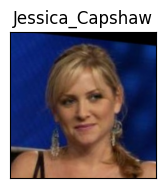

In [42]:
random_name = random.choice(names)
name, num_images = random_name.split("\t")
print(f"Gold: {name}")
      
preds = []
for img in name2img[name]:
    pred = get_close_faces(img, embeddings, device)
    preds.append(pred)
draw_pred_face(name, preds)

### Some tips:
- Quality of Training Data Matters Most: The quality of your training dataset is paramount. Ensure it is diverse, representative, and covers various age groups, ethnicities, poses, and lighting conditions. Low-quality or biased training data can severely impact your model's accuracy.

- Data Augmentation for Robustness: Data augmentation techniques, such as random rotations, scaling, and brightness adjustments, can help improve the model's robustness. Experiment with different augmentations to make the model more adaptable to real-world scenarios.

- Use Transfer Learning: Leveraging pre-trained models (e.g., from the ImageNet dataset) as a starting point can save time and improve performance. Fine-tune these models on your face recognition dataset to adapt them to your specific task.

- Face Detection Preprocessing: Ensure effective face detection as a preprocessing step. Choose a robust face detection model (e.g., MTCNN or RetinaFace) to locate faces in images accurately.

- Thresholding and Confidence Scores: Implement thresholding mechanisms and confidence scores to control the model's decisions. This can help reduce false positives or negatives in recognition tasks.

- Liveness Detection: If security is a concern, consider incorporating liveness detection mechanisms to distinguish between real faces and spoof attempts, such as using a printed photo.